In [0]:
!pip install --upgrade tables
!pip install eli5

In [0]:
import pandas as pd
import numpy as np

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import cross_val_score

import eli5
from eli5.sklearn import PermutationImportance

In [9]:
# Data read
df = pd.read_hdf("data/car.h5")
df.shape

(106494, 155)

In [13]:
# Dummy model
df.select_dtypes(np.number).columns

Index(['price_value', 'car_id'], dtype='object')

In [15]:
feats = ['car_id']
X = df[ feats ].values # = df[ ['car_id'] ].values
y = df['price_value'].values

model = DummyRegressor()
model.fit(X,y) # train
y_pred = model.predict(X) # predict

mae(y, y_pred) # mean abs error

39465.934630440985

In [16]:
[x for x in df.columns if "price" in x]

['price_currency', 'price_details', 'price_value']

In [18]:
df['price_currency'].value_counts()

PLN    106290
EUR       204
Name: price_currency, dtype: int64

In [20]:
df['price_currency'].value_counts(normalize=True)

PLN    0.998084
EUR    0.001916
Name: price_currency, dtype: float64

In [0]:
df = df[df['price_currency'] != "EUR"]

In [40]:
# Features
df["param_color"].factorize()
df["param_color"].factorize()[0]

array([-1, -1, -1, ..., -1, -1, -1])

In [0]:
# factorize all features
SUFFIX_CAT = "__cat"

In [0]:
for feat in df.columns:
  if isinstance(df[feat][0], list): continue
    
  factorized_values = df[feat].factorize()[0]
  if SUFFIX_CAT in feat:
    df[feat] = factorized_values
  else:
    df[feat + SUFFIX_CAT] = factorized_values

In [52]:
cat_feats = [x for x in df.columns if SUFFIX_CAT in x]
cat_feats = [x for x in cat_feats if "price" not in x]
len(cat_feats)

151

In [53]:
# preparation for model 
X = df[cat_feats].values
y = y = df['price_value'].values

model = DecisionTreeRegressor(max_depth=5)

scores = cross_val_score(model, X, y, cv=3, scoring="neg_mean_absolute_error")

np.mean(scores)

-19650.45289201444

In [58]:
m = DecisionTreeRegressor(max_depth=5)
m.fit(X,y)

imp = PermutationImportance(m, random_state = 0).fit(X,y)
eli5.show_weights(imp, feature_names=cat_feats)

Weight,Feature
0.1956 ± 0.0054,param_faktura-vat__cat
0.1903 ± 0.0027,param_napęd__cat
0.1815 ± 0.0087,param_stan__cat
0.1512 ± 0.0078,param_rok-produkcji__cat
0.0928 ± 0.0019,param_skrzynia-biegów__cat
0.0607 ± 0.0051,param_moc__cat
0.0436 ± 0.0015,feature_kamera-cofania__cat
0.0191 ± 0.0022,param_pojemność-skokowa__cat
0.0162 ± 0.0004,feature_bluetooth__cat
0.0110 ± 0.0007,feature_łopatki-zmiany-biegów__cat


In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
# define plotting function from last day
def group_n_barplot(df, feat_groupby,
                    feat_agg='price_value',
                    agg_funs=[np.mean, np.median, np.size],
                    feat_sort="mean",
                    top=60,
                    subplots=True):
  return(
        df
       .groupby(feat_groupby)[feat_agg]
       .agg(agg_funs)
       .sort_values(by=feat_sort, ascending=False)
       .head(top)
  ).plot(kind='bar', figsize=(15,8), subplots=subplots)

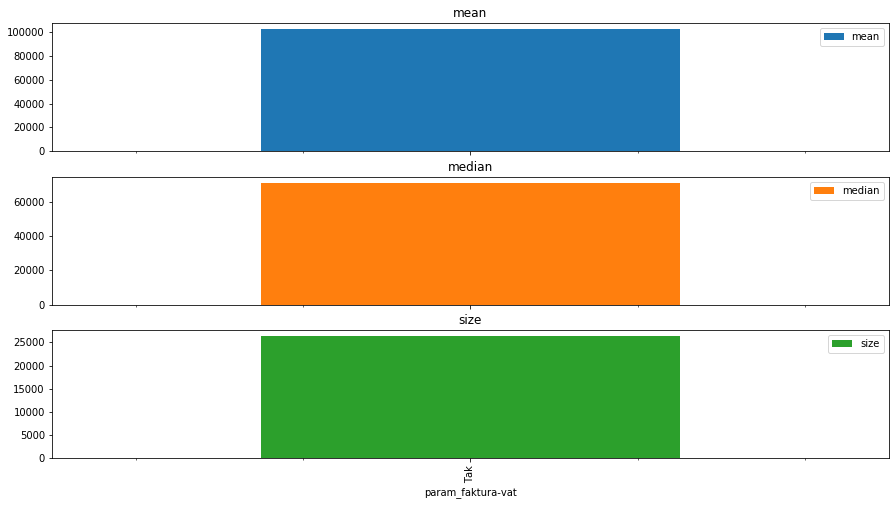

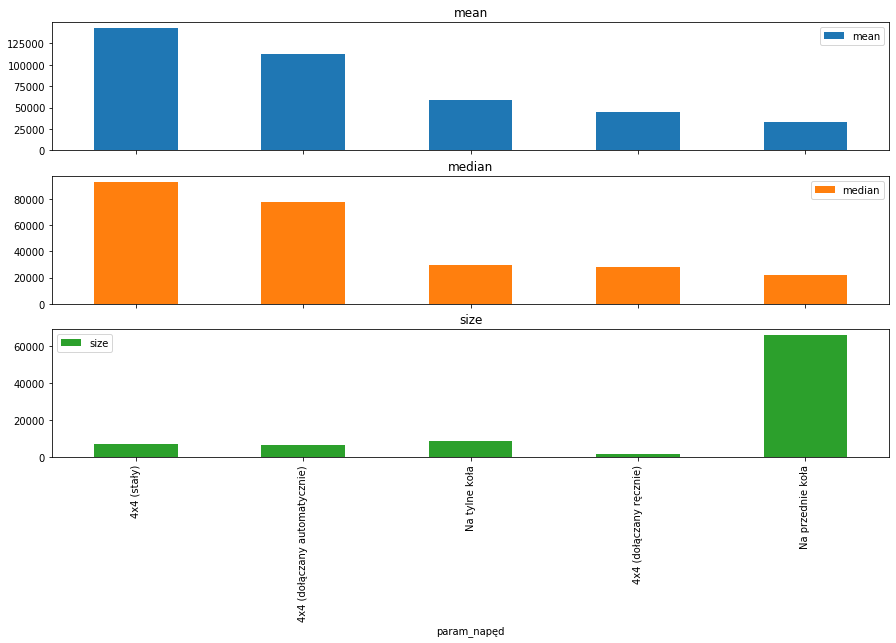

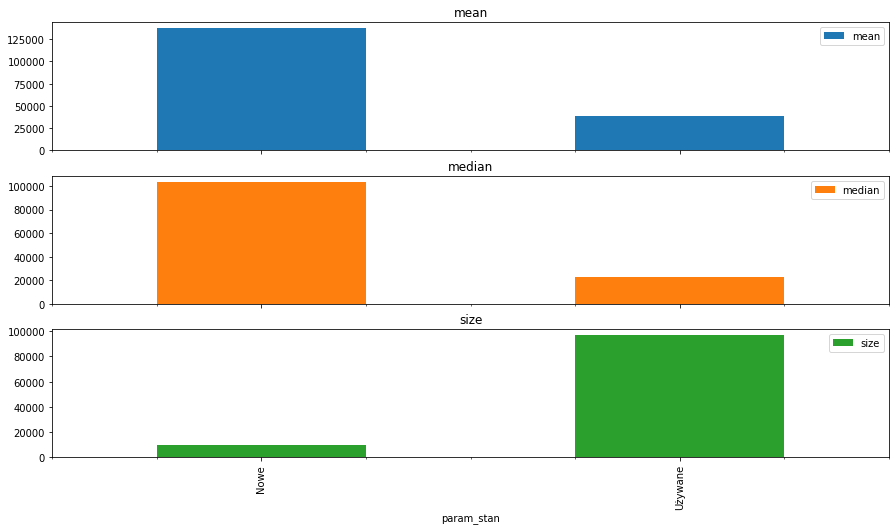

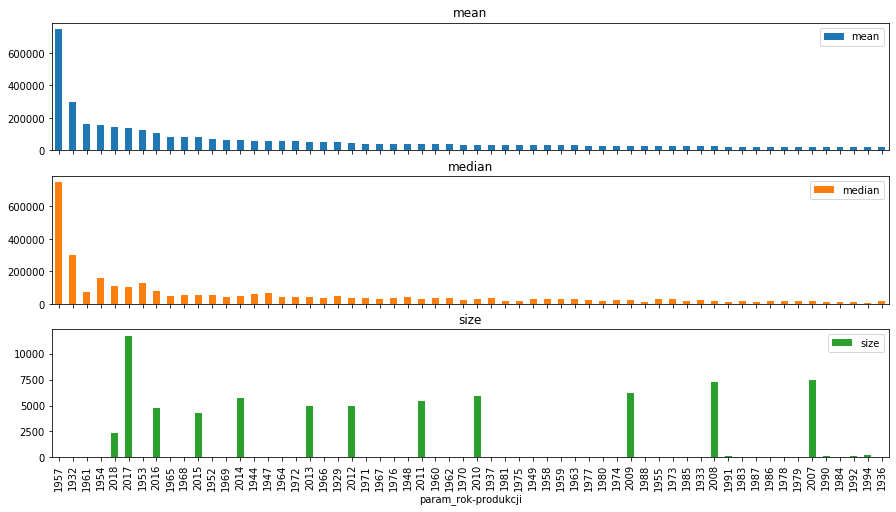

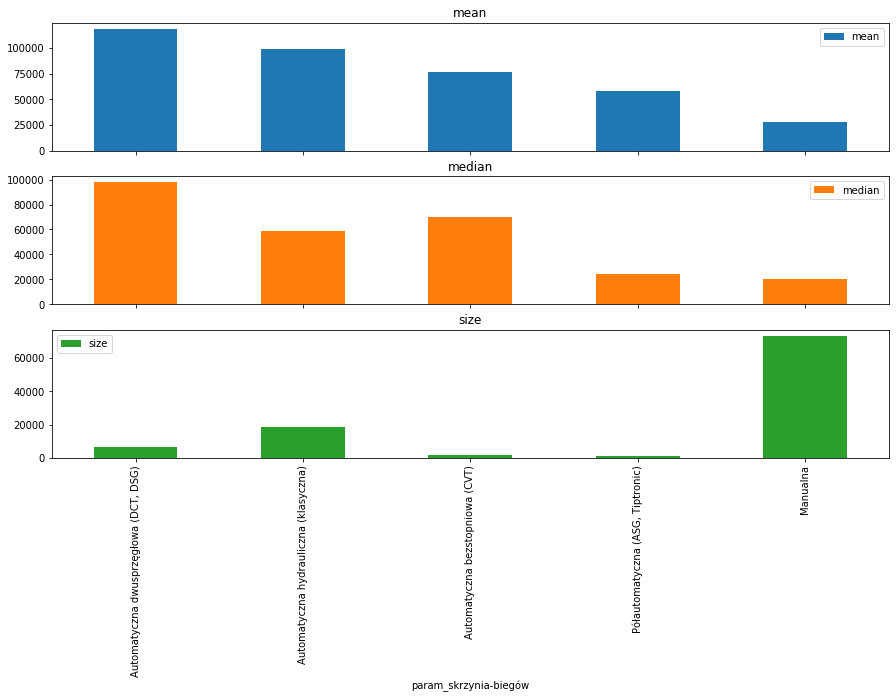

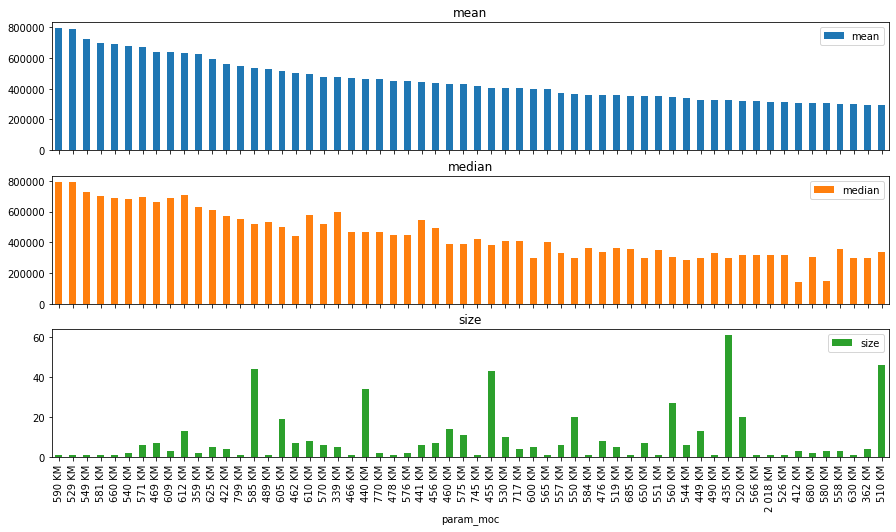

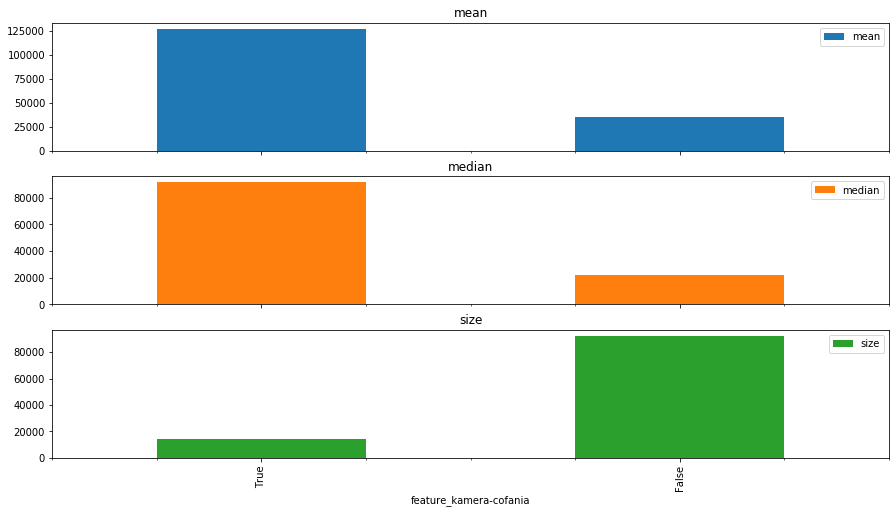

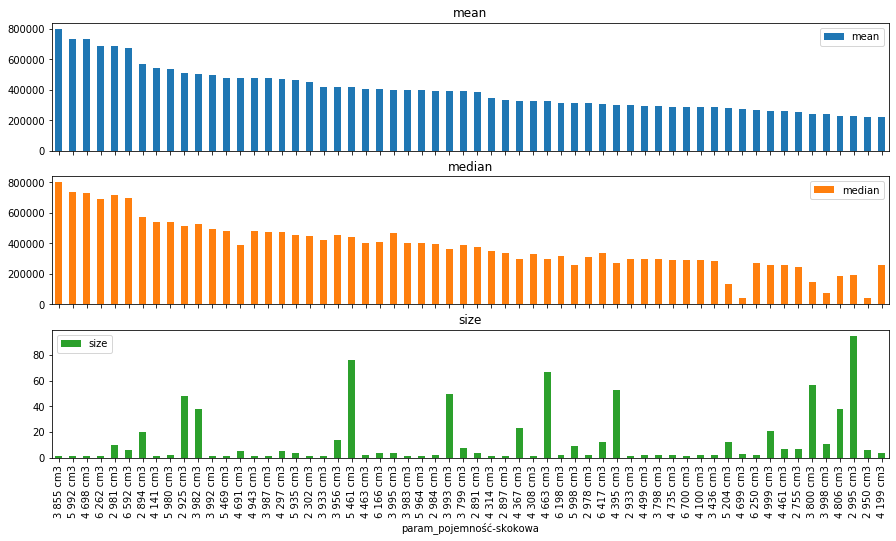

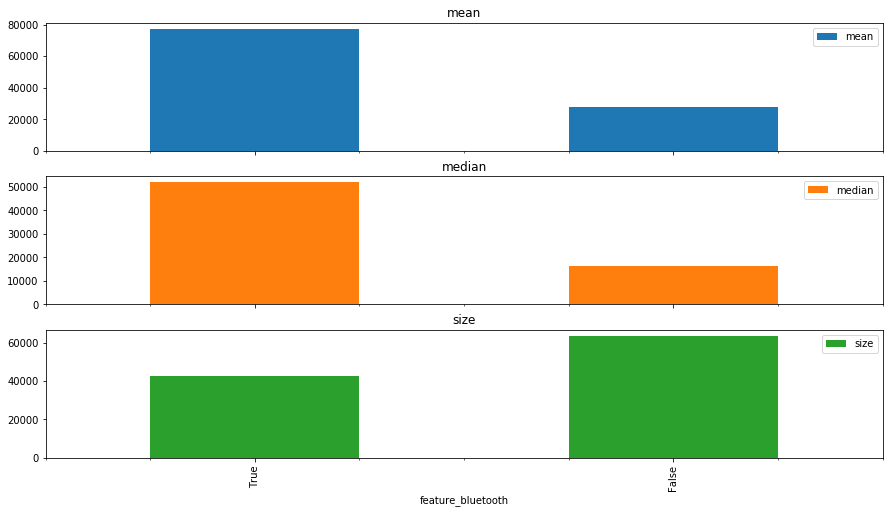

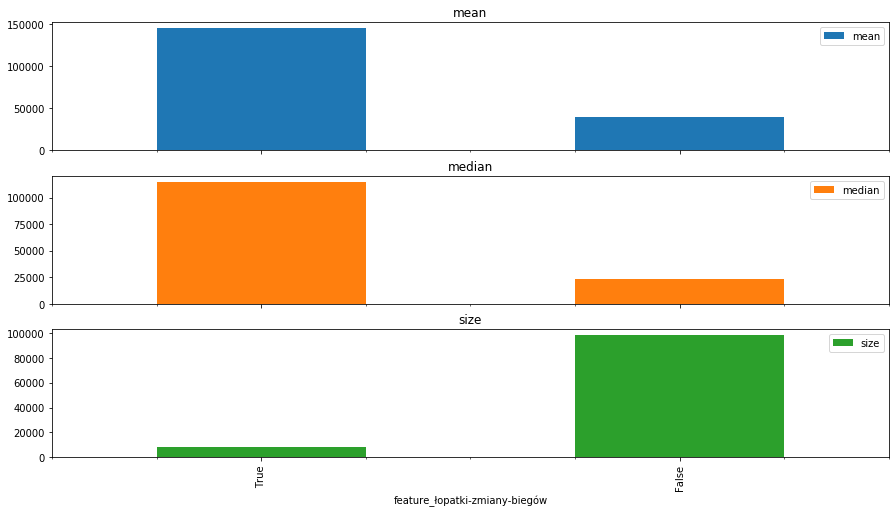

In [90]:
# plot top 10 features in dataset
important_f = eli5.formatters.as_dataframe.explain_weights_df(imp, feature_names=cat_feats)
important_f = important_f[0:10].feature

for i in important_f:
  # remove the suffix to plot real features and not vectorized ones
   i = (i[:-5])
   group_n_barplot(df, i)